# Assignment: Transfer Learning

Transfer learning has become a powerful technique in deep learning, particularly in computer vision tasks, where training large models from scratch can be computationally expensive and require vast amounts of labeled data. The core idea of transfer learning is to leverage knowledge learned by a model on a large dataset, such as ImageNet, and apply it to a different but related task with limited data.
In this project, we explore transfer learning using the ResNet-18 architecture pre-trained on ImageNet. By reusing the pre-trained model's learned features, we significantly reduce the training time and computational resources required to build an image classifier for a subset of the Food-101 dataset.

### **Preparing the Food-101 Dataset for Transfer Learning**
In this step, we will:
1. **Select 15 random classes** from the Food-101 dataset.
2. **Apply necessary preprocessing**:
   - Resize images to **224x224** (required for ResNet).
   - Normalize pixel values.
   - Convert images to PyTorch tensors.
3. **Create training and test DataLoaders** for efficient processing.
4. **Log dataset details in Weights & Biases (W&B)** for tracking.
5. **Visualize some sample images** from the dataset to verify correctness.

By doing this, we ensure that the dataset is **properly formatted for ResNet-18 training** and **logged for reproducibility**.


Using device: cuda


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dsarma (usf-guardians) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 5.00G/5.00G [03:53<00:00, 21.4MB/s]


Selected classes: ['ramen', 'carrot_cake', 'beef_carpaccio', 'strawberry_shortcake', 'escargots', 'donuts', 'croque_madame', 'cheesecake', 'caprese_salad', 'sashimi', 'oysters', 'caesar_salad', 'pho', 'hot_and_sour_soup', 'beef_tartare']


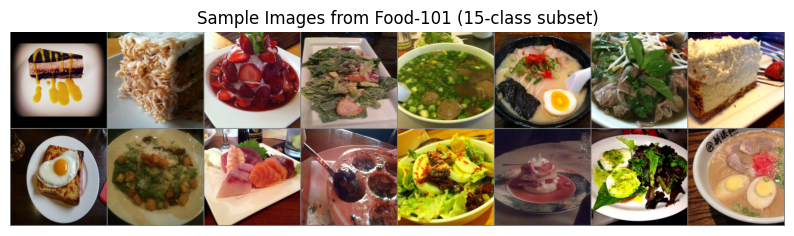

Total training images: 11250
Total testing images: 3750
Using batch size: 32


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import wandb
from torchvision.datasets import Food101
from torch.utils.data import DataLoader, Subset
import random

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set repeatability
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Initialize Weights & Biases (W&B)
wandb.init(project="GoTG_Assignment05_TransferLearning", entity="usf-guardians")

# Load the full Food-101 dataset to get all class names
full_train_dataset = Food101(root="./data", split="train", download=True)
all_classes = full_train_dataset.classes  # Get all 101 class names

# Randomly select 15 classes
random.seed(seed)  # Ensures same class selection across runs
selected_classes = random.sample(all_classes, 15)
print("Selected classes:", selected_classes)

# Define transformations for training and testing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet requires 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1] range
])

# Reload datasets with transformations
full_train_dataset = Food101(root="./data", split="train", transform=transform, download=False)
full_test_dataset = Food101(root="./data", split="test", transform=transform, download=False)

# Create a mapping for our 15 classes to indices (0-14)
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(selected_classes)}

# Function to filter and remap dataset labels
def filter_and_remap(dataset):
    filtered_data = []
    for i in range(len(dataset)):
        class_name = dataset.classes[dataset._labels[i]]
        if class_name in selected_classes:
            new_label = class_to_idx[class_name]  # Map original label to new label (0–14)
            filtered_data.append((dataset[i][0], new_label))  # Store image with remapped label
    return filtered_data

# Apply filtering and remapping
train_subset = filter_and_remap(full_train_dataset)
test_subset = filter_and_remap(full_test_dataset)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

# Log dataset information to W&B
wandb.config.update({
    "dataset": "Food-101 (15-class subset)",
    "num_classes": len(selected_classes),
    "selected_classes": selected_classes,
    "train_size": len(train_subset),
    "test_size": len(test_subset),
    "batch_size": batch_size,
    "image_size": "224x224",
    "normalization": "Mean: [0.5, 0.5, 0.5], Std: [0.5, 0.5, 0.5]"
})

# Function to unnormalize and show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid of images
img_grid = torchvision.utils.make_grid(images[:16])

# Show images
plt.figure(figsize=(10, 5))
imshow(img_grid)
plt.title("Sample Images from Food-101 (15-class subset)")
plt.show()

# Log sample images to W&B
wandb.log({"sample_images": [wandb.Image(images[i], caption=f"Class {labels[i].item()}") for i in range(16)]})

print(f"Total training images: {len(train_subset)}")
print(f"Total testing images: {len(test_subset)}")
print(f"Using batch size: {batch_size}")


In [ ]:
# Verify label range in train loader
label_check = set()
for images, labels in train_loader:
    label_check.update(labels.numpy())  # Collect unique labels
    if len(label_check) == 15:  # If all 15 classes are found, break early
        break

print("Unique labels in training set:", sorted(label_check))
print("Expected labels: 0 to 14")

# Check if all 15 labels are present
if sorted(label_check) == list(range(15)):
    print("✅ Labels correctly mapped to range [0-14]")
else:
    print("❌ Warning: Some labels are missing or incorrectly mapped!")


Unique labels in training set: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14)]
Expected labels: 0 to 14
✅ Labels correctly mapped to range [0-14]


## Model Setup and Preparation

- **Pre-trained ResNet-18** is loaded with ImageNet weights.
- The final fully connected (FC) layer is modified to output **15 classes** for our dataset.
- **Feature Extraction Approach**:
  - All layers are frozen except the final FC layer.
  - Only the FC layer's weights will be updated during training.
- **W&B Logging**:
  - Model details, number of trainable and total parameters, and the training approach are logged.
  - `wandb.watch()` is enabled to track gradients and parameter updates.
- The model is moved to the **GPU** if available for faster training.


In [ ]:
import torch
import torchvision
import torch.nn as nn
import wandb

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ResNet-18 model
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Print the original model structure
print("Original model:")
print(model.fc)  # The final fully connected layer

# Modify the final layer for 15 classes
num_features = model.fc.in_features  # Get number of input features to the final layer
model.fc = nn.Linear(num_features, 15)  # Change output layer to 15 classes

# Print the modified model
print("\nModified model:")
print(model.fc)

# Move model to the device (GPU if available)
model = model.to(device)

# Log model details to W&B
wandb.config.update({
    "model": "ResNet-18",
    "pretrained": True,
    "num_classes": 15,
    "input_features": num_features
})

# Setup W&B to track model parameters and gradients
wandb.watch(model, log="all", log_freq=100)

# Freeze all layers except the final fully connected (fc) layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze only the final FC layer so it can be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Count and print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")

# Log trainable parameters to W&B
wandb.config.update({
    "trainable_params": trainable_params,
    "total_params": total_params,
    "approach": "feature_extraction"
})


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


Original model:
Linear(in_features=512, out_features=1000, bias=True)

Modified model:
Linear(in_features=512, out_features=15, bias=True)
Trainable parameters: 7,695 (0.07% of total)


## Functions to log to Weights & Biases

### 📌 W&B Logging Functions Overview

This script contains helper functions to log important details during model training using **Weights & Biases (W&B)**:

- **Dataset Info**: Logs dataset name, number of classes, size, and normalization used.
- **Model Info**: Logs model architecture (ResNet-18), pretrained status, and tracks gradients.
- **Training Hyperparameters**: Logs learning rate, optimizer, loss function, and number of epochs.
- **Epoch Metrics**: Logs training/testing loss, accuracy, F1 scores, and per-class accuracy every epoch.
- **Confusion Matrix**: Logs class-wise confusion matrix to visualize model performance.
- **Best Model**: Saves and logs the best model checkpoint along with best accuracy and F1.
- **Model Artifact**: Saves any model checkpoint as a W&B artifact for versioning.

These functions help maintain organized tracking, reproducibility, and easier model comparison.


In [ ]:
import torch
import wandb
import torch.nn as nn

# 🔹 Function to Log Dataset Information
def log_dataset_info(selected_classes, train_subset, test_subset, batch_size):
    wandb.config.update({
        "dataset": "Food-101 (15-class subset)",
        "num_classes": len(selected_classes),
        "selected_classes": selected_classes,
        "train_size": len(train_subset),
        "test_size": len(test_subset),
        "batch_size": batch_size,
        "image_size": "224x224",
        "normalization": "Mean: [0.5, 0.5, 0.5], Std: [0.5, 0.5, 0.5]"
    })

# 🔹 Function to Log Model Information
def log_model_info(model, num_features):
    wandb.config.update({
        "model": "ResNet-18",
        "pretrained": True,
        "num_classes": 15,
        "input_features": num_features
    })

    # Setup W&B to track model parameters and gradients
    wandb.watch(model, log="all", log_freq=100)

# 🔹 Function to Log Training Hyperparameters
def log_training_hyperparams(learning_rate, optimizer_name, epochs):
    wandb.config.update({
        "architecture": "ResNet-18",
        "learning_rate": learning_rate,
        "optimizer": optimizer_name,
        "criterion": "CrossEntropyLoss",
        "epochs": epochs
    })

# 🔹 Function to Log Epoch Metrics
def log_epoch_metrics(epoch, train_loss, train_acc, train_f1, test_loss, test_acc, test_f1, class_acc):
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1_macro": train_f1,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "test_f1_macro": test_f1
    })

    # Log per-class accuracy
    wandb.log(class_acc)

# 🔹 Function to Log Confusion Matrix
def log_confusion_matrix(true_labels, pred_labels):
    wandb.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=true_labels,
            preds=pred_labels,
            class_names=[str(i) for i in range(15)]
        )
    })

# 🔹 Function to Log Best Model (Stores Best Accuracy & F1 Score)
def log_best_model(model, epoch, best_acc, best_f1):
    model_path = f"resnet18_food101_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), model_path)

    artifact = wandb.Artifact(name="resnet18-food101-best", type="model", description="Best performing model")
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

    # Update W&B summary with best metrics
    wandb.run.summary["best_accuracy"] = best_acc
    wandb.run.summary["best_f1_macro"] = best_f1
    wandb.run.summary["best_epoch"] = epoch + 1

# 🔹 Function to Log Model Artifacts (Ensuring State Dict Matches Expected Keys)
def log_model_artifact(model, name="model_checkpoint", description="Trained model checkpoint"):
    model_path = f"{name}.pth"

    # Ensure FC Layer is NOT Wrapped in Sequential() Before Saving
    if isinstance(model.fc, nn.Sequential):
        model.fc = model.fc[0]  # Remove activation before saving

    torch.save(model.state_dict(), model_path)

    artifact = wandb.Artifact(name=name, type="model", description=description)
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

    print(f"✅ Model artifact '{name}' logged to W&B")


# Phase 1

- Loaded the pre-trained ResNet-18 model.
- Replaced the final fully connected (FC) layer with a new layer outputting 15 classes.
- Froze all layers except the final FC layer.
- Ran two experiments each with different hyperparameter combinations to evaluate performance.


## Run 1

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
from sklearn.metrics import f1_score

# Define architecture, learning rate, and optimizer for this first run
architecture = "ResNet-18"
learning_rate = 0.001
optimizer_name = "Adam"
epochs = 10

# Initialize optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

# 🔹 Log hyperparameters
log_training_hyperparams(learning_rate, optimizer_name, epochs)

# Define the training loop
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_preds = []
        all_train_labels = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total
        train_f1_macro = f1_score(all_train_labels, all_train_preds, average='macro')

        # Validation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        class_correct = [0] * 15
        class_total = [0] * 15
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = test_loss / len(test_loader.dataset)
        test_acc = 100. * correct / total
        test_f1_macro = f1_score(all_labels, all_preds, average='macro')

        # Compute per-class accuracy
        class_acc_dict = {f"class_acc_{i}": 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(15)}

        # 🔹 Log epoch metrics and confusion matrix
        log_epoch_metrics(epoch, train_loss, train_acc, train_f1_macro, test_loss, test_acc, test_f1_macro, class_acc_dict)
        log_confusion_matrix(all_labels, all_preds)

        # 🔹 Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_f1 = test_f1_macro
            log_best_model(model, epoch, best_acc, best_f1)

        # 🔹 Log Model Artifact for Each Epoch (Ensuring State Dict Matches Expected Keys)
        log_model_artifact(model, name=f"resnet18_epoch{epoch+1}")

    print(f'Best test accuracy: {best_acc:.2f}%')
    return model

# Run training with the logging functions
model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=epochs)

# Finish W&B run
wandb.finish()


Epoch 1/10
----------
✅ Model artifact 'resnet18_epoch1' logged to W&B
Epoch 2/10
----------
✅ Model artifact 'resnet18_epoch2' logged to W&B
Epoch 3/10
----------
✅ Model artifact 'resnet18_epoch3' logged to W&B
Epoch 4/10
----------
✅ Model artifact 'resnet18_epoch4' logged to W&B
Epoch 5/10
----------
✅ Model artifact 'resnet18_epoch5' logged to W&B
Epoch 6/10
----------
✅ Model artifact 'resnet18_epoch6' logged to W&B
Epoch 7/10
----------
✅ Model artifact 'resnet18_epoch7' logged to W&B
Epoch 8/10
----------
✅ Model artifact 'resnet18_epoch8' logged to W&B
Epoch 9/10
----------
✅ Model artifact 'resnet18_epoch9' logged to W&B
Epoch 10/10
----------
✅ Model artifact 'resnet18_epoch10' logged to W&B
Best test accuracy: 80.56%


class_acc_0,▃█▇▅▅▆▁▅▂▂
class_acc_1,▂▆▃▅▃▁▃█▅▇
class_acc_10,▁▆▅▄▁▄▃▃█▃
class_acc_11,▃▁█▇▆▃▄█▂▆
class_acc_12,▄▁▂▂▆▂▅▁▇█
class_acc_13,▆▁▃▆▅▅▇█▄▄
class_acc_14,▁▆▆▆█▇▆▆▅▄
class_acc_2,▃▂▁▂▄▅█▅▆▄
class_acc_3,█▆▅█▇▆▁▃▁▂
class_acc_4,▁█▂▅▆▇▇▇▇▇
class_acc_5,▅▂▃▁▂▁▇▃▇█


## 📊 Model Training Results - ResNet-18 (Food-101 15-Class Subset)

The model achieved a **best test accuracy of 80.56%** at **epoch 8**, with a **macro F1-score of 0.80603**, indicating balanced performance across all classes. Final training results at epoch 10 show **train accuracy of 78.99%** and **test accuracy of 80.45%**, with losses of **0.656 (train) and 0.589 (test)**, suggesting good generalization without significant overfitting.

Performance varied across classes, with the highest accuracy in **Class 5 (94%) and Class 12 (90.8%)**, while **Class 7 had the lowest accuracy (55.2%)**, indicating possible misclassification issues. To further improve, we can fine-tune more layers, apply data augmentation for underperforming classes, and analyze the confusion matrix to identify misclassification patterns. 🚀


------------------------------------------------------------------------------

## **Trying a New Hyperparameter Combination 1 (Same Architecture)**
Now that we have completed one experiment, we will start a **new independent experiment** with:
✅ The **same ResNet-18 architecture**  
✅ A **new learning rate**  
✅ A **different optimizer**  
✅ A **new batch size**  

#### **What We Will Change in This Run**
1. **Keep using ResNet-18** (same model architecture for consistency).  
2. **Change the learning rate** from `0.001` to `0.0005` for finer weight updates.  
3. **Keep the optimizer** as **Adam**
4. **Increase batch size** from `32` to `64` for more stable updates.  
5. **Log this as a new independent run** in W&B to compare results.  

This experiment helps us understand how **hyperparameters influence performance**, keeping model architecture constant.

##Run 2

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
import torchvision
from sklearn.metrics import f1_score

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define new hyperparameters for this experiment
architecture = "ResNet-18"
learning_rate = 0.0005
optimizer_name = "Adam"
batch_size = 64  # Increased batch size for more stable updates
epochs = 10

# Use the same ResNet-18 model as before
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Modify the final layer for 15 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 15)

# Move model to GPU (if available)
model = model.to(device)

# Freeze all layers except the final FC layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

# Initialize new optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

# 🔹 Start a new W&B run for this experiment
wandb.init(
    project="GoTG_Assignment05_TransferLearning",
    entity="usf-guardians",
    name=f"{architecture}_LR{learning_rate}_Adam_BS{batch_size}_DJ1"
)

# 🔹 Log everything (dataset, model, hyperparameters)
log_dataset_info(selected_classes, train_subset, test_subset, batch_size)
log_model_info(model, num_features)
log_training_hyperparams(learning_rate, optimizer_name, epochs)

# Create a new DataLoader with updated batch size
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

# Training function with structured logging
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_preds = []
        all_train_labels = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total
        train_f1_macro = f1_score(all_train_labels, all_train_preds, average='macro')

        # Validation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        class_correct = [0] * 15
        class_total = [0] * 15
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = test_loss / len(test_loader.dataset)
        test_acc = 100. * correct / total
        test_f1_macro = f1_score(all_labels, all_preds, average='macro')

        # Compute per-class accuracy
        class_acc_dict = {f"class_acc_{i}": 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(15)}

        # 🔹 Log all metrics properly
        log_epoch_metrics(epoch, train_loss, train_acc, train_f1_macro, test_loss, test_acc, test_f1_macro, class_acc_dict)
        log_confusion_matrix(all_labels, all_preds)

        # 🔹 Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_f1 = test_f1_macro
            log_best_model(model, epoch, best_acc, best_f1)

        # 🔹 Log model artifact for each epoch
        log_model_artifact(model, name=f"resnet18_epoch{epoch+1}")

    print(f'Best test accuracy: {best_acc:.2f}%')
    return model

# Run the training function for this experiment
model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=epochs)

# Finish W&B run
wandb.finish()


Using device: cuda


Epoch 1/10
----------
✅ Model artifact 'resnet18_epoch1' logged to W&B
Epoch 2/10
----------
✅ Model artifact 'resnet18_epoch2' logged to W&B
Epoch 3/10
----------
✅ Model artifact 'resnet18_epoch3' logged to W&B
Epoch 4/10
----------
✅ Model artifact 'resnet18_epoch4' logged to W&B
Epoch 5/10
----------
✅ Model artifact 'resnet18_epoch5' logged to W&B
Epoch 6/10
----------
✅ Model artifact 'resnet18_epoch6' logged to W&B
Epoch 7/10
----------
✅ Model artifact 'resnet18_epoch7' logged to W&B
Epoch 8/10
----------
✅ Model artifact 'resnet18_epoch8' logged to W&B
Epoch 9/10
----------
✅ Model artifact 'resnet18_epoch9' logged to W&B
Epoch 10/10
----------
✅ Model artifact 'resnet18_epoch10' logged to W&B
Best test accuracy: 80.69%


class_acc_0,▁▆▅█▇▇▅█▇▆
class_acc_1,▆▃▆▅█▁▆▃▆▅
class_acc_10,█▃▅▅▁█▅▁▇▆
class_acc_11,▁▃▄▆█▇▇▆▇█
class_acc_12,▅▂▅▁█▇█▃▇▇
class_acc_13,▁▆█▇▄▃▆▃▅▃
class_acc_14,▁▇▆▆▆▆▆██▇
class_acc_2,▁▁▇▇▄█▆▄▅▅
class_acc_3,▃▄▃▄▂▄▄▁▆█
class_acc_4,▁▇███▆▇▇▇█
class_acc_5,▁▆▆▅▆▇▆█▅█


## 📊 Model Training Results - ResNet-18 (Food-101 15-Class Subset)

The model achieved a **best test accuracy of 80.69%** at **epoch 10**, with a **macro F1-score of 0.80657**, indicating consistent performance across all classes. Final training results show **train accuracy of 78.69%** and **test accuracy of 80.64%**, with losses of **0.702 (train) and 0.615 (test)**. The slightly higher train loss suggests the model is **generalizing well** without severe overfitting.

Per-class accuracy shows strong performance in **Class 5 (both 91.6%)**, while **Class 7 had the lowest accuracy (62.8%)**, suggesting possible misclassification issues. Compared to the previous experiment, accuracy remains stable, with slight variations in class-wise performance. Further improvements can be explored by fine-tuning more layers, experimenting with data augmentation, or adjusting learning rates. 🚀


--------------------------------------------------------------------------------

## **Trying a New Hyperparameter Combination 2 (Same Architecture)**
Now that we have completed one experiment, we will start a new independent experiment with:

✅ The same ResNet-18 architecture

✅ A new learning rate

✅ A different loss function

✅ The Adam optimizer

✅ A new batch size

#### **What We Will Change in This Run**
1. **Keep using ResNet-18** (same model architecture for consistency).
2. **Change the loss function to Label Smoothing Cross Entropy** (label_smoothing=0.1) to make training more robust.
3. **Keep the optimizer** as **Adam** for adaptive learning rates.
4. **Increase batch size** from 32 to 64 for more stable updates.
5. **Log this as a new independent run** in W&B to compare results.


This experiment helps us understand how **hyperparameters influence performance**, keeping model architecture constant.

##Run 3

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
import torchvision
from sklearn.metrics import f1_score

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define new hyperparameters for this experiment
architecture = "ResNet-18"
learning_rate = 0.0005
optimizer_name = "Adam"
batch_size = 64
epochs = 10

# Use the same ResNet-18 model as before
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Modify the final layer for 15 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 15)

# Move model to GPU (if available)
model = model.to(device)

# Freeze all layers except the final FC layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

# Initialize optimizer and updated loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

# W&B Logging
wandb.init(
    project="GoTG_Assignment05_TransferLearning",
    entity="usf-guardians",
    name=f"{architecture}_LR{learning_rate}_Adam_BS{batch_size}_DJ2"
)

# 🔹 Log everything (dataset, model, hyperparameters)
log_dataset_info(selected_classes, train_subset, test_subset, batch_size)
log_model_info(model, num_features)
log_training_hyperparams(learning_rate, optimizer_name, epochs)

# Create a new DataLoader with updated batch size
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=1)

# Training function with structured logging
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_preds = []
        all_train_labels = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total
        train_f1_macro = f1_score(all_train_labels, all_train_preds, average='macro')

        # Validation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        class_correct = [0] * 15
        class_total = [0] * 15
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = test_loss / len(test_loader.dataset)
        test_acc = 100. * correct / total
        test_f1_macro = f1_score(all_labels, all_preds, average='macro')

        # Compute per-class accuracy
        class_acc_dict = {f"class_acc_{i}": 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(15)}

        # 🔹 Log all metrics properly
        log_epoch_metrics(epoch, train_loss, train_acc, train_f1_macro, test_loss, test_acc, test_f1_macro, class_acc_dict)
        log_confusion_matrix(all_labels, all_preds)

        # 🔹 Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_f1 = test_f1_macro
            log_best_model(model, epoch, best_acc, best_f1)

        # 🔹 Log model artifact for each epoch
        log_model_artifact(model, name=f"resnet18_epoch{epoch+1}")

    print(f'Best test accuracy: {best_acc:.2f}%')
    return model

# Run the training function for this experiment
model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=epochs)

# Finish W&B run
wandb.finish()

Using device: cuda
Epoch 1/10
----------
✅ Model artifact 'resnet18_epoch1' logged to W&B
Epoch 2/10
----------
✅ Model artifact 'resnet18_epoch2' logged to W&B
Epoch 3/10
----------
✅ Model artifact 'resnet18_epoch3' logged to W&B
Epoch 4/10
----------
✅ Model artifact 'resnet18_epoch4' logged to W&B
Epoch 5/10
----------
✅ Model artifact 'resnet18_epoch5' logged to W&B
Epoch 6/10
----------
✅ Model artifact 'resnet18_epoch6' logged to W&B
Epoch 7/10
----------
✅ Model artifact 'resnet18_epoch7' logged to W&B
Epoch 8/10
----------
✅ Model artifact 'resnet18_epoch8' logged to W&B
Epoch 9/10
----------
✅ Model artifact 'resnet18_epoch9' logged to W&B
Epoch 10/10
----------
✅ Model artifact 'resnet18_epoch10' logged to W&B
Best test accuracy: 80.83%


class_acc_0,▁▅▃▆▅▆▄█▅█
class_acc_1,▁▇▆▆▆▇▃▃▆█
class_acc_10,▁▅▂▂▃▂▆▂█▆
class_acc_11,▃▃▅▁█▇▄▇▆▆
class_acc_12,▆▅▇▆▅▇█▃▇▁
class_acc_13,▅▆▆▆▆▆▇▁█▇
class_acc_14,▁▄█▆▅▆▄▆▅▆
class_acc_2,▁▅▄▆▅▆█▆▇▆
class_acc_3,▄▁▃▁▄▁▇█▃▂
class_acc_4,▁▅▅▄█▅▆▅▇▆
class_acc_5,▃▃▂▁▄▆▅█▅▅


## 📊 Model Training Results - ResNet-18 (Food-101 15-Class Subset) - Combination 2

The model achieved a **best test accuracy of 80.82%** at **epoch 10**, with a **macro F1-score of 0.8074**, indicating consistent performance across all classes. Final training results show **train accuracy of 78.94%** and **test accuracy of 80.50%**, with losses of **1.16 (train) and 1.11 (test)**. The slightly higher train loss suggests the model is **generalizing well** without severe overfitting.

Per-class accuracy shows strong performance in **Class 13 (both 92%)**, while **Class 3 had the lowest accuracy (67.2%)**, suggesting possible misclassification issues. Compared to the previous experiment, accuracy remains stable, with slight variations in class-wise performance. Further improvements can be explored by fine-tuning more layers, experimenting with data augmentation, or adjusting learning rates. 🚀


--------------------------------------------------------------------------------

## **Trying a New Hyperparameter Combination 3 (Same Architecture)**
Now that we have completed one experiment, we will start a new independent experiment with:

✅ The same ResNet-18 architecture

✅ A new learning rate

✅ A different loss function

✅ The Adam optimizer

✅ A new batch size

#### **What We Will Change in This Run**
1. **Keep using ResNet-18** (same model architecture for consistency).
2. **Change the loss function to Label Smoothing Cross Entropy** (label_smoothing=0.1) to make training more robust.
3. **Change the optimizer** from Adam to **SGD with Momentum** (momentum=0.9) to improve convergence stability.
4. **Same batch size** of 64 for more stable updates.
5. **Increase epochs** from 10 to 15 for better convergence.
6. **Log this as a new independent run** in W&B to compare results.


This experiment helps us understand how **hyperparameters influence performance**, keeping model architecture constant.

##Run 4

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
import torchvision
from sklearn.metrics import f1_score

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define new hyperparameters for this experiment
architecture = "ResNet-18"
learning_rate = 0.0005
optimizer_name = "SGD"
batch_size = 64
epochs = 15

# Use the same ResNet-18 model as before
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Modify the final layer for 15 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 15)

# Move model to GPU (if available)
model = model.to(device)

# Freeze all layers except the final FC layer
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

# Initialize optimizer and updated loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=0.9)

# W&B Logging
wandb.init(
    project="GoTG_Assignment05_TransferLearning",
    entity="usf-guardians",
    name=f"{architecture}_LR{learning_rate}_SGD_BS{batch_size}"
)


# 🔹 Log everything (dataset, model, hyperparameters)
log_dataset_info(selected_classes, train_subset, test_subset, batch_size)
log_model_info(model, num_features)
log_training_hyperparams(learning_rate, optimizer_name, epochs)

# Create a new DataLoader with updated batch size
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

# Training function with structured logging
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_preds = []
        all_train_labels = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total
        train_f1_macro = f1_score(all_train_labels, all_train_preds, average='macro')

        # Validation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        class_correct = [0] * 15
        class_total = [0] * 15
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = test_loss / len(test_loader.dataset)
        test_acc = 100. * correct / total
        test_f1_macro = f1_score(all_labels, all_preds, average='macro')

        # Compute per-class accuracy
        class_acc_dict = {f"class_acc_{i}": 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(15)}

        # 🔹 Log all metrics properly
        log_epoch_metrics(epoch, train_loss, train_acc, train_f1_macro, test_loss, test_acc, test_f1_macro, class_acc_dict)
        log_confusion_matrix(all_labels, all_preds)

        # 🔹 Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_f1 = test_f1_macro
            log_best_model(model, epoch, best_acc, best_f1)

        # 🔹 Log model artifact for each epoch
        log_model_artifact(model, name=f"resnet18_epoch{epoch+1}")

    print(f'Best test accuracy: {best_acc:.2f}%')
    return model

# Run the training function for this experiment
model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=epochs)

# Finish W&B run
wandb.finish()

Using device: cuda


Epoch 1/15
----------
✅ Model artifact 'resnet18_epoch1' logged to W&B
Epoch 2/15
----------
✅ Model artifact 'resnet18_epoch2' logged to W&B
Epoch 3/15
----------
✅ Model artifact 'resnet18_epoch3' logged to W&B
Epoch 4/15
----------
✅ Model artifact 'resnet18_epoch4' logged to W&B
Epoch 5/15
----------
✅ Model artifact 'resnet18_epoch5' logged to W&B
Epoch 6/15
----------
✅ Model artifact 'resnet18_epoch6' logged to W&B
Epoch 7/15
----------
✅ Model artifact 'resnet18_epoch7' logged to W&B
Epoch 8/15
----------
✅ Model artifact 'resnet18_epoch8' logged to W&B
Epoch 9/15
----------
✅ Model artifact 'resnet18_epoch9' logged to W&B
Epoch 10/15
----------
✅ Model artifact 'resnet18_epoch10' logged to W&B
Epoch 11/15
----------
✅ Model artifact 'resnet18_epoch11' logged to W&B
Epoch 12/15
----------
✅ Model artifact 'resnet18_epoch12' logged to W&B
Epoch 13/15
----------
✅ Model artifact 'resnet18_epoch13' logged to W&B
Epoch 14/15
----------
✅ Model artifact 'resnet18_epoch14' logged to 

class_acc_0,▁▄▃▆▇▇▇██▆▇▇▇▇▇
class_acc_1,▁▆█▆▄▆▃▅▆▅▅▅▆▅▅
class_acc_10,▁▅▆▅▇▇▆▆▇▇█▇▇▇▇
class_acc_11,▁▃▇▆▆██▆▇█▇▇█▇▇
class_acc_12,▁▄█▇▅▇▇▆▇▇▇▆▆█▆
class_acc_13,▁▆▅▃▆▅▆▅▅▇▆▇█▆▆
class_acc_14,▁▄▆▇▇▇▇█▇▇▇████
class_acc_2,▁▄▄▇▇▆▇▇▆▇▇█▆▇▇
class_acc_3,▁▇▆▇▆▇▆▇███▇▇██
class_acc_4,▁▅▅▆▇▇▇████▇███
class_acc_5,▁▆█▇▇██▇█▇▇█▇▇█


## 📊 Model Training Results - ResNet-18 (Food-101 15-Class Subset) - Combination 3

The model achieved a **best test accuracy of 79.49%** at **epoch 15**, with a **macro F1-score of 0.7942**, indicating consistent performance across all classes. Final training results show **train accuracy of 76.59%** and **test accuracy of 79.49%**, with losses of **1.22 (train) and 1.15 (test)**. The slightly higher train loss suggests the model is **generalizing well** without severe overfitting.

Per-class accuracy shows strong performance in **Class 5 and Class 13 (both 90.4%)**, while **Class 7 had the lowest accuracy (62.4%)**, suggesting possible misclassification issues. Compared to the previous experiment, accuracy remains stable, with slight variations in class-wise performance. Further improvements can be explored by fine-tuning more layers, experimenting with data augmentation, or adjusting learning rates. 🚀


--------------------------------------------------------------------------------

# Phase 2 - I
- Loaded the best checkpoint from Phase 1.  
- Unfroze Layer4 and FC layer for fine-tuning while keeping earlier layers frozen.  
- Conducted two fine-tuning experiments with different hyperparameters per run.  

## **Fine-Tuning More Layers & Running Another Experiment**  
Now that we have tested different hyperparameters, it's time to **unlock more layers for fine-tuning** and run another experiment.  

#### **What We Will Do in This Run**  
1. **Load the previously trained model** and resume training.  
2. **Unfreeze ResNet's last block (layer4) along with the final fully connected (fc) layer** to allow fine-tuning.  
3. **Use a smaller learning rate** for better control:  
   - Lower LR (`0.0002`) for **layer4** (to prevent drastic weight updates).  
   - Slightly higher LR (`0.0015`) for **fc layer** (to allow better adaptation).  
4. **Run another independent experiment in W&B**, logging:  
   - Training & validation metrics (loss, accuracy, F1-score).  
   - **Confusion matrix & per-class accuracy**.  
   - **Best model artifact to W&B** for tracking & reproducibility.  

This fine-tuning phase helps **improve model performance while avoiding catastrophic forgetting**.  

## Run 5  

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
import torchvision
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import StepLR

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 🔹 New Fine-tuning Hyperparameters for this experiment
architecture = "ResNet-18"
fine_tune_epochs = 5                 # Slightly longer training
learning_rate_layer4 = 0.0002         # Lower LR for layer4
learning_rate_fc = 0.0015             # Higher LR for fc
weight_decay = 1e-5                   # Small weight decay
step_size = 5                         # Scheduler step size
gamma = 0.5                           # Scheduler decay rate

# Load pretrained ResNet-18 model
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 15)
model = model.to(device)

# Unfreeze layer4 and fc for fine-tuning
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

# 🔹 Optimizer: RMSprop (new optimizer choice for variety)
optimizer = optim.RMSprop([
    {'params': model.layer4.parameters(), 'lr': learning_rate_layer4},
    {'params': model.fc.parameters(), 'lr': learning_rate_fc}
], weight_decay=weight_decay, momentum=0.9)

# 🔹 Learning Rate Scheduler
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

# 🔹 Start a new W&B run for this fine-tuning experiment
wandb.init(
    project="GoTG_Assignment05_TransferLearning",
    entity="usf-guardians",
    name="ResNet18_FineTune_Experiment4_RMSprop"
)

# 🔹 Log dataset, model, and hyperparameters
log_dataset_info(selected_classes, train_subset, test_subset, batch_size)
log_model_info(model, model.fc.in_features)
log_training_hyperparams(f"{learning_rate_fc} (with scheduler)", "RMSprop (momentum=0.9, wd=1e-5)", fine_tune_epochs)

# Training function with LR scheduler support
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=5):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_preds = []
        all_train_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        scheduler.step()  # 🔹 Step the scheduler every epoch

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total
        train_f1_macro = f1_score(all_train_labels, all_train_preds, average='macro')

        # Validation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        class_correct = [0] * 15
        class_total = [0] * 15
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = test_loss / len(test_loader.dataset)
        test_acc = 100. * correct / total
        test_f1_macro = f1_score(all_labels, all_preds, average='macro')

        # Per-class accuracy
        class_acc_dict = {f"class_acc_{i}": 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(15)}

        # 🔹 Log metrics and confusion matrix
        log_epoch_metrics(epoch, train_loss, train_acc, train_f1_macro, test_loss, test_acc, test_f1_macro, class_acc_dict)
        log_confusion_matrix(all_labels, all_preds)

        # 🔹 Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            log_best_model(model, epoch, best_acc, test_f1_macro)

        # 🔹 Log model artifact per epoch
        log_model_artifact(model, name=f"resnet18_finetune_exp4_epoch{epoch+1}")

    print(f'Best test accuracy: {best_acc:.2f}%')
    return model

# Loss function
criterion = nn.CrossEntropyLoss()

# 🔹 Train model with scheduler
model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=fine_tune_epochs)

# 🔹 Finish W&B run
wandb.finish()


#Phase 2 - II
- Loaded the best checkpoint from Phase 1.  
- Unfroze Layer4 and FC layer for fine-tuning while keeping earlier layers frozen.  
- Conducted two fine-tuning experiments with different hyperparameters per run.  

## **Fine-Tuning More Layers & Running Another Experiment**  
Now that we have tested different hyperparameters, it's time to **unlock more layers for fine-tuning** and run another experiment.  

#### **What We Will Do in This Run**  
1. **Load the previously trained model** and resume training.  
2. **Unfreeze ResNet's last block (layer4) along with the final fully connected (fc) layer** to allow fine-tuning.  
3. **Adjusting learning rate**:  
   - Higher LR (`0.0007`) for **layer4**.  
   - Moderate LR (`0.001`) for **fc layer** for stable adaptation.  
4. **Run another independent experiment in W&B**, logging:  
   - Training & validation metrics (loss, accuracy, F1-score).  
   - **Confusion matrix & per-class accuracy**.  
   - **Best model artifact to W&B** for tracking & reproducibility.  

This fine-tuning phase helps **improve model performance while avoiding catastrophic forgetting**.  

## Run 6

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
import torchvision
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import CosineAnnealingLR

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 🔹 Fine-tuning Hyperparameters for Experiment 5
architecture = "ResNet-18"
fine_tune_epochs = 10                 # Testing slightly longer fine-tuning
learning_rate_layer4 = 0.0007         # Higher LR for layer4
learning_rate_fc = 0.001              # Moderate LR for fc
weight_decay = 1e-3                   # Higher weight decay for regularization

# Load pretrained ResNet-18 model
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 15)
model = model.to(device)

# Unfreeze layer4 and fc for fine-tuning
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

# 🔹 Optimizer: Adamax (different optimizer) with higher weight decay
optimizer = optim.Adamax([
    {'params': model.layer4.parameters(), 'lr': learning_rate_layer4},
    {'params': model.fc.parameters(), 'lr': learning_rate_fc}
], weight_decay=weight_decay)

# 🔹 Cosine Annealing LR Scheduler for smooth LR decay
scheduler = CosineAnnealingLR(optimizer, T_max=fine_tune_epochs)

# 🔹 Start a new W&B run for Experiment 5
wandb.init(
    project="GoTG_Assignment05_TransferLearning",
    entity="usf-guardians",
    name="ResNet18_FineTune_Experiment5_Adamax"
)

# 🔹 Log dataset, model, and hyperparameters
log_dataset_info(selected_classes, train_subset, test_subset, batch_size)
log_model_info(model, model.fc.in_features)
log_training_hyperparams(f"{learning_rate_fc} (Cosine Annealing)", "Adamax (weight_decay=1e-3)", fine_tune_epochs)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_preds = []
        all_train_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        scheduler.step()  # 🔹 Update LR using cosine annealing

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total
        train_f1_macro = f1_score(all_train_labels, all_train_preds, average='macro')

        # Validation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        class_correct = [0] * 15
        class_total = [0] * 15
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = test_loss / len(test_loader.dataset)
        test_acc = 100. * correct / total
        test_f1_macro = f1_score(all_labels, all_preds, average='macro')

        # Per-class accuracy
        class_acc_dict = {f"class_acc_{i}": 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(15)}

        # 🔹 Log metrics and confusion matrix
        log_epoch_metrics(epoch, train_loss, train_acc, train_f1_macro, test_loss, test_acc, test_f1_macro, class_acc_dict)
        log_confusion_matrix(all_labels, all_preds)

        # 🔹 Save best model checkpoint
        if test_acc > best_acc:
            best_acc = test_acc
            log_best_model(model, epoch, best_acc, test_f1_macro)

        log_model_artifact(model, name=f"resnet18_finetune_exp5_epoch{epoch+1}")

    print(f'Best test accuracy: {best_acc:.2f}%')
    return model

# Loss function
criterion = nn.CrossEntropyLoss()

# 🔹 Train model with Adamax and Cosine LR Scheduler
model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=fine_tune_epochs)

# 🔹 Finish W&B run
wandb.finish()

### **Fine-Tuning with Unlocked Layer & New Hyperparameters**
Now that we have unlocked **layer4 and fc**, we will run a **new fine-tuning experiment** with:
✅ A **different learning rate**  
✅ A **different optimizer**  
✅ **Logging full dataset information** for tracking consistency  

---

#### **What Changes in This Run?**
1. **Unfreezing ResNet's `layer4` and `fc` layers** for fine-tuning.  
2. **Using RMSprop instead of Adam** (handles dynamic learning rates better).  
3. **Reducing the learning rate** to `0.00005` for more gradual updates.  
4. **Keeping the fully connected (`fc`) layer learning rate at `0.0005`** to adapt classification.  
5. **Logging everything** (dataset details, hyperparameters, performance, confusion matrix, and artifacts).  

##Run 7
---

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
import torchvision
from sklearn.metrics import f1_score

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define new fine-tuning parameters
architecture = "ResNet-18"
fine_tune_epochs = 10
learning_rate_layer4 = 0.00005  # Smaller learning rate for layer4
learning_rate_fc = 0.0005  # Faster updates for fully connected layer
optimizer_name = "RMSprop"

# Load the trained model from previous feature extraction phase
model = torchvision.models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 15)  # Ensure the final layer matches dataset

# Load trained weights from previous experiment
model.load_state_dict(torch.load("resnet18_food101_epoch_10.pth"))
model = model.to(device)

# Unfreeze layer4 and fc for fine-tuning
for param in model.parameters():
    param.requires_grad = False  # Keep all layers frozen initially

for param in model.layer4.parameters():
    param.requires_grad = True  # Unfreeze layer4

for param in model.fc.parameters():
    param.requires_grad = True  # Unfreeze final fully connected layer

# Define new optimizer with separate learning rates
optimizer = optim.RMSprop([
    {'params': model.layer4.parameters(), 'lr': learning_rate_layer4, 'alpha': 0.99},
    {'params': model.fc.parameters(), 'lr': learning_rate_fc, 'alpha': 0.99}
])

# 🔹 Start a new W&B run for fine-tuning
wandb.init(
    project="GoTG_Assignment05_TransferLearning",
    entity="usf-guardians",
    name="Take2_ResNet18_FineTune_RMSprop"
)

# 🔹 Log everything before training
log_dataset_info(selected_classes, train_subset, test_subset, batch_size)
log_model_info(model, model.fc.in_features)
log_training_hyperparams(learning_rate_fc, optimizer_name, fine_tune_epochs)

# Training function with structured logging
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    best_f1 = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_preds = []
        all_train_labels = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total
        train_f1_macro = f1_score(all_train_labels, all_train_preds, average='macro')

        # Validation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        class_correct = [0] * 15
        class_total = [0] * 15
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = test_loss / len(test_loader.dataset)
        test_acc = 100. * correct / total
        test_f1_macro = f1_score(all_labels, all_preds, average='macro')

        # Compute per-class accuracy
        class_acc_dict = {f"class_acc_{i}": 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(15)}

        # 🔹 Log all metrics properly
        log_epoch_metrics(epoch, train_loss, train_acc, train_f1_macro, test_loss, test_acc, test_f1_macro, class_acc_dict)
        log_confusion_matrix(all_labels, all_preds)

        # 🔹 Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_f1 = test_f1_macro
            best_epoch = epoch + 1
            log_best_model(model, epoch, best_acc, best_f1)

        # 🔹 Log model artifact for each epoch
        log_model_artifact(model, name=f"resnet18_finetune_epoch{epoch+1}")

    print(f'Best test accuracy: {best_acc:.2f}% (Epoch {best_epoch})')
    return model

# Train the model with fine-tuning
model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=fine_tune_epochs)

# Finish W&B run
wandb.finish()


Using device: cuda


Epoch 1/10
----------
✅ Model artifact 'resnet18_finetune_epoch1' logged to W&B
Epoch 2/10
----------
✅ Model artifact 'resnet18_finetune_epoch2' logged to W&B
Epoch 3/10
----------
✅ Model artifact 'resnet18_finetune_epoch3' logged to W&B
Epoch 4/10
----------
✅ Model artifact 'resnet18_finetune_epoch4' logged to W&B
Epoch 5/10
----------
✅ Model artifact 'resnet18_finetune_epoch5' logged to W&B
Epoch 6/10
----------
✅ Model artifact 'resnet18_finetune_epoch6' logged to W&B
Epoch 7/10
----------
✅ Model artifact 'resnet18_finetune_epoch7' logged to W&B
Epoch 8/10
----------
✅ Model artifact 'resnet18_finetune_epoch8' logged to W&B
Epoch 9/10
----------
✅ Model artifact 'resnet18_finetune_epoch9' logged to W&B
Epoch 10/10
----------
✅ Model artifact 'resnet18_finetune_epoch10' logged to W&B
Best test accuracy: 89.23% (Epoch 8)


class_acc_0,▁▄▆▅▆██▆▆▆
class_acc_1,█▆▆▃▇▅▆▆▅▁
class_acc_10,▂▁▂▁▆▅▃█▃█
class_acc_11,▁▂█▆▄▅█▆▄▅
class_acc_12,▃▆▆█▇▆▇▅▅▁
class_acc_13,█▃▁▃▃█▁█▁█
class_acc_14,▁█▃▇▁▃▄▃▅█
class_acc_2,▄▁▃▄▅▄▇▄▆█
class_acc_3,▃▃▂▇▁▃█▇▃▃
class_acc_4,█▄▃▆▇▇▃▆█▁
class_acc_5,▁▆▆▄▅▄▅▆▅█


# Phase 3
- Performed random sweeps using Weights & Biases (W&B) to automatically test multiple hyperparameter combinations.
- Explored optimizers, learning rates, weight decay, batch sizes, and activation functions.
- Ran 10 sweep runs each selecting the best configuration.

## Sweep Runs (Run 8)

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
import torchvision
from sklearn.metrics import f1_score

# 🔹 Define Sweep Configuration
sweep_config = {
    "method": "random",  # Random search
    "metric": {"name": "test_acc", "goal": "maximize"},
    "parameters": {
        "learning_rate_layer4": {"values": [0.0001, 0.00005]},  # 2 values
        "learning_rate_fc": {"values": [0.001, 0.0005]},  # 2 values
        "optimizer": {"values": ["Adam", "RMSprop", "SGD"]},  # 3 optimizers
        "batch_size": {"values": [32, 64]},  # 2 batch sizes
        "weight_decay": {"values": [0.0001, 0.0005]},  # 2 values
        "activation": {"values": ["ReLU", "LeakyReLU"]},  # 2 activation functions
        "epochs": {"value": 10}, # Fixed at 10
        "label_smoothing": {"values": [0.0, 0.1]},  # Added Label Smoothing
    }
}

# 🔹 Initialize the Sweep
sweep_id = wandb.sweep(sweep_config, project="GoTG_Assignment05_TransferLearning")


# 🔹 Function to Log Model Artifacts (Ensuring State Dict Matches Expected Keys)
def log_model_artifact(model, name="model_checkpoint", description="Trained model checkpoint"):
    model_path = f"{name}.pth"

    # 🔹 Ensure FC Layer is NOT Wrapped in Sequential() Before Saving
    if isinstance(model.fc, nn.Sequential):
        model.fc = model.fc[0]  # Remove activation before saving

    torch.save(model.state_dict(), model_path)

    artifact = wandb.Artifact(name=name, type="model", description=description)
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

    print(f"✅ Model artifact '{name}' logged to W&B")


# 🔹 Training Function Using W&B Sweep
def train():
    # 🔹 Initialize W&B run with sweep config
    wandb.init()

    # 🔹 Get hyperparameters from W&B
    learning_rate_layer4 = wandb.config.learning_rate_layer4
    learning_rate_fc = wandb.config.learning_rate_fc
    optimizer_name = wandb.config.optimizer
    batch_size = wandb.config.batch_size
    weight_decay = wandb.config.weight_decay
    activation_name = wandb.config.activation
    epochs = wandb.config.epochs  # Fixed at 10
    label_smoothing = wandb.config.label_smoothing

    # 🔹 Load Pretrained Model
    model = torchvision.models.resnet18(weights=None)

    # 🔹 Ensure FC Layer Matches Default Before Loading Weights
    model.fc = nn.Linear(model.fc.in_features, 15)  # Ensure structure matches before loading weights

    # 🔹 Load Trained Weights (Ensure Structure Matches)
    checkpoint = torch.load("resnet18_food101_epoch_10.pth")

    # 🔹 Fix Key Mismatch if FC Was Wrapped in Sequential() Before Saving
    new_state_dict = {}
    for key, value in checkpoint.items():
        new_key = key.replace("fc.0.", "fc.")  # Remove Sequential() wrapper naming
        new_state_dict[new_key] = value

    model.load_state_dict(new_state_dict)

    # 🔹 Move Model to GPU (IMPORTANT: Must move before modifying FC layer)
    model = model.to(device)

    # 🔹 Unfreeze layer4 and fc for fine-tuning
    for param in model.parameters():
        param.requires_grad = False
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.fc.parameters():
        param.requires_grad = True

    # 🔹 Modify FC Layer **AFTER** Loading Weights (Ensures Compatibility)
    activation_fn = getattr(nn, activation_name)().to(device)
    model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 15), activation_fn).to(device)

    # 🔹 Define Optimizer
    if optimizer_name == "SGD":
        optimizer = optim.SGD([
            {'params': model.layer4.parameters(), 'lr': learning_rate_layer4, 'momentum': 0.9, 'weight_decay': weight_decay},
            {'params': model.fc.parameters(), 'lr': learning_rate_fc, 'weight_decay': weight_decay}
        ])
    else:
        optimizer = getattr(optim, optimizer_name)([
            {'params': model.layer4.parameters(), 'lr': learning_rate_layer4, 'weight_decay': weight_decay},
            {'params': model.fc.parameters(), 'lr': learning_rate_fc, 'weight_decay': weight_decay}
        ])

    # 🔹 Create DataLoaders with New Batch Size
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=1)

    # 🔹 LOG EVERYTHING BEFORE TRAINING

    log_model_info(model, model.fc[0].in_features)  # Model details
    log_training_hyperparams(learning_rate_fc, optimizer_name, epochs)  # Hyperparameters

    # 🔹 Train Model
    model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=epochs)

    # 🔹 Save & Log Best Model
    log_model_artifact(model, name=f"best_model_{wandb.run.name}", description="Best performing model in sweep")

    # 🔹 Finish W&B Run
    wandb.finish()


# 🔹 Run the Sweep
wandb.agent(sweep_id, function=train, count=10)  # Runs 10 different experiments


Create sweep with ID: as5tljsj
Sweep URL: https://wandb.ai/usf-guardians/GoTG_Assignment05_TransferLearning/sweeps/as5tljsj


wandb: Agent Starting Run: qhlik632 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	label_smoothing: 0
wandb: 	learning_rate_fc: 0.001
wandb: 	learning_rate_layer4: 5e-05
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.0001


wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).


Epoch 1/10
----------
✅ Model artifact 'resnet18_epoch1' logged to W&B
Epoch 2/10
----------
✅ Model artifact 'resnet18_epoch2' logged to W&B
Epoch 3/10
----------
✅ Model artifact 'resnet18_epoch3' logged to W&B
Epoch 4/10
----------
✅ Model artifact 'resnet18_epoch4' logged to W&B
Epoch 5/10
----------
✅ Model artifact 'resnet18_epoch5' logged to W&B
Epoch 6/10
----------
✅ Model artifact 'resnet18_epoch6' logged to W&B
Epoch 7/10
----------
✅ Model artifact 'resnet18_epoch7' logged to W&B
Epoch 8/10
----------
✅ Model artifact 'resnet18_epoch8' logged to W&B
Epoch 9/10
----------
✅ Model artifact 'resnet18_epoch9' logged to W&B
Epoch 10/10
----------
✅ Model artifact 'resnet18_epoch10' logged to W&B
Best test accuracy: 88.99%
✅ Model artifact 'best_model_amber-sweep-1' logged to W&B


class_acc_0,▁▇██▇██▇▇▇
class_acc_1,▁▇█▇██████
class_acc_10,▁█████████
class_acc_11,█▆▅▁▂▂▁▄▅▅
class_acc_12,▁▇▇███████
class_acc_13,█▂▃▂▃▁▅▄▄▁
class_acc_14,▅▄▁▃▅█▅▆▂▅
class_acc_2,▂▂▇▄▁▅▄▄██
class_acc_3,▁▇▇▇██▇▇▇▇
class_acc_4,▁█████████
class_acc_5,█▄▁▃▄▃▃▄▃▂


wandb: Agent Starting Run: vzgcg4fo with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate_fc: 0.001
wandb: 	learning_rate_layer4: 5e-05
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0.0005


wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).


Epoch 1/10
----------
✅ Model artifact 'resnet18_epoch1' logged to W&B
Epoch 2/10
----------
✅ Model artifact 'resnet18_epoch2' logged to W&B
Epoch 3/10
----------
✅ Model artifact 'resnet18_epoch3' logged to W&B
Epoch 4/10
----------
✅ Model artifact 'resnet18_epoch4' logged to W&B
Epoch 5/10
----------
✅ Model artifact 'resnet18_epoch5' logged to W&B
Epoch 6/10
----------
✅ Model artifact 'resnet18_epoch6' logged to W&B
Epoch 7/10
----------
✅ Model artifact 'resnet18_epoch7' logged to W&B
Epoch 8/10
----------
✅ Model artifact 'resnet18_epoch8' logged to W&B
Epoch 9/10
----------
✅ Model artifact 'resnet18_epoch9' logged to W&B
Epoch 10/10
----------
✅ Model artifact 'resnet18_epoch10' logged to W&B
Best test accuracy: 88.80%
✅ Model artifact 'best_model_stilted-sweep-2' logged to W&B


class_acc_0,▁▇▇███▇▇▇▇
class_acc_1,▇█▆▁▁▂▃▆▅▅
class_acc_10,▁█▇▇█▅▄▇▆▅
class_acc_11,▁███████▇█
class_acc_12,▁▆▅▄▄▃▄▅█▅
class_acc_13,▁▃▅▃▅▆█▇▆▇
class_acc_14,▁▇██▇▇██▇█
class_acc_2,▁▇████████
class_acc_3,▁▇▇▇▇█▇▇██
class_acc_4,█▅▃▃▁▅▁▅▇▄
class_acc_5,▁█████████


wandb: Agent Starting Run: 7z1906cs with config:
wandb: 	activation: LeakyReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate_fc: 0.0005
wandb: 	learning_rate_layer4: 5e-05
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0.0005


wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).


Epoch 1/10
----------
✅ Model artifact 'resnet18_epoch1' logged to W&B
Epoch 2/10
----------
✅ Model artifact 'resnet18_epoch2' logged to W&B
Epoch 3/10
----------
✅ Model artifact 'resnet18_epoch3' logged to W&B
Epoch 4/10
----------
✅ Model artifact 'resnet18_epoch4' logged to W&B
Epoch 5/10
----------
✅ Model artifact 'resnet18_epoch5' logged to W&B
Epoch 6/10
----------
✅ Model artifact 'resnet18_epoch6' logged to W&B
Epoch 7/10
----------
✅ Model artifact 'resnet18_epoch7' logged to W&B
Epoch 8/10
----------
✅ Model artifact 'resnet18_epoch8' logged to W&B
Epoch 9/10
----------
✅ Model artifact 'resnet18_epoch9' logged to W&B
Epoch 10/10
----------
✅ Model artifact 'resnet18_epoch10' logged to W&B
Best test accuracy: 88.93%
✅ Model artifact 'best_model_ruby-sweep-3' logged to W&B


class_acc_0,█▂▃▆▅▁▄██▅
class_acc_1,▆▂▄▃▇▄▁▅█▄
class_acc_10,▆▁▂▇▆▆██▆█
class_acc_11,▁▃▆▂▆▄▆▄█▃
class_acc_12,▅█▇▆▆▇█▁▅▆
class_acc_13,▃▆█▅▆▆▆█▁▅
class_acc_14,▄█▆▁▃▂▄▆▄█
class_acc_2,▆▁▃█▅▇▃▅▅▅
class_acc_3,▅█▅▄▄▄▁▅▄▅
class_acc_4,▇▃▆▂▅▅▇▃█▁
class_acc_5,▄▁▃▃█▂▁▄▅▁


wandb: Agent Starting Run: 9yhoctk5 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate_fc: 0.001
wandb: 	learning_rate_layer4: 0.0001
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.0005


wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).


Epoch 1/10
----------
✅ Model artifact 'resnet18_epoch1' logged to W&B
Epoch 2/10
----------
✅ Model artifact 'resnet18_epoch2' logged to W&B
Epoch 3/10
----------
✅ Model artifact 'resnet18_epoch3' logged to W&B
Epoch 4/10
----------
✅ Model artifact 'resnet18_epoch4' logged to W&B
Epoch 5/10
----------
✅ Model artifact 'resnet18_epoch5' logged to W&B
Epoch 6/10
----------
✅ Model artifact 'resnet18_epoch6' logged to W&B
Epoch 7/10
----------
✅ Model artifact 'resnet18_epoch7' logged to W&B
Epoch 8/10
----------
✅ Model artifact 'resnet18_epoch8' logged to W&B
Epoch 9/10
----------
✅ Model artifact 'resnet18_epoch9' logged to W&B
Epoch 10/10
----------
✅ Model artifact 'resnet18_epoch10' logged to W&B
Best test accuracy: 89.92%
✅ Model artifact 'best_model_magic-sweep-4' logged to W&B


class_acc_0,█▃▂▁▃▃▄▂▄▁
class_acc_1,▁▇█▇███▇▇█
class_acc_10,▇▃▁▇▃▆▅▄█▅
class_acc_11,▁█▇███████
class_acc_12,▁█████████
class_acc_13,▅▁▃▅█▇▇█▄▇
class_acc_14,▇█▁▃▃▄▅▃▅▅
class_acc_2,▅▆▁▅▂█▄▆▄▇
class_acc_3,▆▃▅▆▆▄▁██▆
class_acc_4,▁█████████
class_acc_5,▁█████████


wandb: Agent Starting Run: chbfmq41 with config:
wandb: 	activation: LeakyReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	label_smoothing: 0
wandb: 	learning_rate_fc: 0.001
wandb: 	learning_rate_layer4: 5e-05
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0.0001


wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).


Epoch 1/10
----------
✅ Model artifact 'resnet18_epoch1' logged to W&B
Epoch 2/10
----------
✅ Model artifact 'resnet18_epoch2' logged to W&B
Epoch 3/10
----------
✅ Model artifact 'resnet18_epoch3' logged to W&B
Epoch 4/10
----------
✅ Model artifact 'resnet18_epoch4' logged to W&B
Epoch 5/10
----------
✅ Model artifact 'resnet18_epoch5' logged to W&B
Epoch 6/10
----------
✅ Model artifact 'resnet18_epoch6' logged to W&B
Epoch 7/10
----------
✅ Model artifact 'resnet18_epoch7' logged to W&B
Epoch 8/10
----------
✅ Model artifact 'resnet18_epoch8' logged to W&B
Epoch 9/10
----------
✅ Model artifact 'resnet18_epoch9' logged to W&B
Epoch 10/10
----------
✅ Model artifact 'resnet18_epoch10' logged to W&B
Best test accuracy: 90.83%
✅ Model artifact 'best_model_usual-sweep-5' logged to W&B


class_acc_0,▂▄▂▁▅▃▁█▁▄
class_acc_1,▇▅▅▇▃▁▅▅▅█
class_acc_10,█▃▄▁▅▄▂███
class_acc_11,▄▁▁▂▂█▂▂▄▄
class_acc_12,▅▄▅█▄▃▄▁▅▅
class_acc_13,█▇█▄▆▇▄▁██
class_acc_14,▅▃▅▅█▁▅▅▂▄
class_acc_2,▁▅▅▅▂▂▅▅▇█
class_acc_3,▁▅█▄▅▁▁▂▇▆
class_acc_4,▂▇▇█▃▁▄▃▄▁
class_acc_5,▅▅█▆█▁▆▅▇▇


wandb: Agent Starting Run: gx4r460p with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate_fc: 0.0005
wandb: 	learning_rate_layer4: 5e-05
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.0005


wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).


Epoch 1/10
----------
✅ Model artifact 'resnet18_epoch1' logged to W&B
Epoch 2/10
----------
✅ Model artifact 'resnet18_epoch2' logged to W&B
Epoch 3/10
----------
✅ Model artifact 'resnet18_epoch3' logged to W&B
Epoch 4/10
----------
✅ Model artifact 'resnet18_epoch4' logged to W&B
Epoch 5/10
----------
✅ Model artifact 'resnet18_epoch5' logged to W&B
Epoch 6/10
----------
✅ Model artifact 'resnet18_epoch6' logged to W&B
Epoch 7/10
----------
✅ Model artifact 'resnet18_epoch7' logged to W&B
Epoch 8/10
----------
✅ Model artifact 'resnet18_epoch8' logged to W&B
Epoch 9/10
----------
✅ Model artifact 'resnet18_epoch9' logged to W&B
Epoch 10/10
----------
✅ Model artifact 'resnet18_epoch10' logged to W&B
Best test accuracy: 90.96%
✅ Model artifact 'best_model_royal-sweep-6' logged to W&B


class_acc_0,█▃▂▄▃▂▅▁▅▇
class_acc_1,▁█████████
class_acc_10,█▇▅▃▇█▁▁█▅
class_acc_11,▄▄▂▃▂█▁▅▅▇
class_acc_12,▇▆▇▅▅▇▂█▁▄
class_acc_13,▁█████████
class_acc_14,█▃▆▃▆▁▆▇▅▄
class_acc_2,▁▆▅▆█▆▇▃▆▆
class_acc_3,▁▇████████
class_acc_4,▁█████████
class_acc_5,█▃▂▂▂▁▄▃▃▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5acar48e with config:
wandb: 	activation: LeakyReLU
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate_fc: 0.001
wandb: 	learning_rate_layer4: 5e-05
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.0001


wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).


Epoch 1/10
----------
✅ Model artifact 'resnet18_epoch1' logged to W&B
Epoch 2/10
----------
✅ Model artifact 'resnet18_epoch2' logged to W&B
Epoch 3/10
----------
✅ Model artifact 'resnet18_epoch3' logged to W&B
Epoch 4/10
----------
✅ Model artifact 'resnet18_epoch4' logged to W&B
Epoch 5/10
----------
✅ Model artifact 'resnet18_epoch5' logged to W&B
Epoch 6/10
----------
✅ Model artifact 'resnet18_epoch6' logged to W&B
Epoch 7/10
----------
✅ Model artifact 'resnet18_epoch7' logged to W&B
Epoch 8/10
----------
✅ Model artifact 'resnet18_epoch8' logged to W&B
Epoch 9/10
----------
✅ Model artifact 'resnet18_epoch9' logged to W&B
Epoch 10/10
----------
✅ Model artifact 'resnet18_epoch10' logged to W&B
Best test accuracy: 91.55%
✅ Model artifact 'best_model_bumbling-sweep-7' logged to W&B


class_acc_0,▁▇████████
class_acc_1,▁█████████
class_acc_10,▁█████████
class_acc_11,██▃▆▁▃▁▆▁▆
class_acc_12,▁█████████
class_acc_13,█▂▁▃▂▃▃▂▂▂
class_acc_14,▄▇▆▄▅▅▄▄▁█
class_acc_2,▁▇▅▇▇▇▅▇█▂
class_acc_3,▁▇████████
class_acc_4,▁█████████
class_acc_5,█▄▂▂▂▂▂▂▂▁


wandb: Agent Starting Run: vbqtp6wi with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate_fc: 0.0005
wandb: 	learning_rate_layer4: 0.0001
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0.0001


wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).


Epoch 1/10
----------
✅ Model artifact 'resnet18_epoch1' logged to W&B
Epoch 2/10
----------
✅ Model artifact 'resnet18_epoch2' logged to W&B
Epoch 3/10
----------
✅ Model artifact 'resnet18_epoch3' logged to W&B
Epoch 4/10
----------
✅ Model artifact 'resnet18_epoch4' logged to W&B
Epoch 5/10
----------
✅ Model artifact 'resnet18_epoch5' logged to W&B
Epoch 6/10
----------
✅ Model artifact 'resnet18_epoch6' logged to W&B
Epoch 7/10
----------
✅ Model artifact 'resnet18_epoch7' logged to W&B
Epoch 8/10
----------
✅ Model artifact 'resnet18_epoch8' logged to W&B
Epoch 9/10
----------
✅ Model artifact 'resnet18_epoch9' logged to W&B
Epoch 10/10
----------
✅ Model artifact 'resnet18_epoch10' logged to W&B
Best test accuracy: 90.48%
✅ Model artifact 'best_model_distinctive-sweep-8' logged to W&B


class_acc_0,█▇▄▅▆▁▄▅▅▅
class_acc_1,▅▁▅▃█▅▃▄▂▇
class_acc_10,▇▆▃▁█▆▃█▆▇
class_acc_11,▆▅▁█▇▃▃▃▃▅
class_acc_12,▁▇█▇▇█████
class_acc_13,▁█████████
class_acc_14,▇▅▁▄▆▃▆▇▇█
class_acc_2,▃▅▇▁▄█▆▃▅▁
class_acc_3,▅█▄▂▅▂▁█▁▄
class_acc_4,▁▃▄▄▇█▇▃▅▃
class_acc_5,▄█▄▃▂▄▁▃▅▂


wandb: Agent Starting Run: gcb6q363 with config:
wandb: 	activation: LeakyReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate_fc: 0.001
wandb: 	learning_rate_layer4: 0.0001
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.0005


wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).


Epoch 1/10
----------
✅ Model artifact 'resnet18_epoch1' logged to W&B
Epoch 2/10
----------
✅ Model artifact 'resnet18_epoch2' logged to W&B
Epoch 3/10
----------
✅ Model artifact 'resnet18_epoch3' logged to W&B
Epoch 4/10
----------
✅ Model artifact 'resnet18_epoch4' logged to W&B
Epoch 5/10
----------
✅ Model artifact 'resnet18_epoch5' logged to W&B
Epoch 6/10
----------
✅ Model artifact 'resnet18_epoch6' logged to W&B
Epoch 7/10
----------
✅ Model artifact 'resnet18_epoch7' logged to W&B
Epoch 8/10
----------
✅ Model artifact 'resnet18_epoch8' logged to W&B
Epoch 9/10
----------
✅ Model artifact 'resnet18_epoch9' logged to W&B
Epoch 10/10
----------
✅ Model artifact 'resnet18_epoch10' logged to W&B
Best test accuracy: 91.52%
✅ Model artifact 'best_model_rosy-sweep-9' logged to W&B


class_acc_0,▁█████████
class_acc_1,▆▃▅▁▄█▁▆▅▇
class_acc_10,▄▁▃▂▂▂▃▄█▄
class_acc_11,▁█████████
class_acc_12,█▄▄▄▄▁▂▃▄▄
class_acc_13,▁█████████
class_acc_14,▇▄▅▅▁▂▁▂▆█
class_acc_2,█▆▄▄▇▁▇█▆▆
class_acc_3,▁█████████
class_acc_4,█▁▃▃▄▄▃▆▄▆
class_acc_5,▁█████████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p7bjegvo with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate_fc: 0.0005
wandb: 	learning_rate_layer4: 0.0001
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0.0005


wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).


Epoch 1/10
----------
✅ Model artifact 'resnet18_epoch1' logged to W&B
Epoch 2/10
----------
✅ Model artifact 'resnet18_epoch2' logged to W&B
Epoch 3/10
----------
✅ Model artifact 'resnet18_epoch3' logged to W&B
Epoch 4/10
----------
✅ Model artifact 'resnet18_epoch4' logged to W&B
Epoch 5/10
----------
✅ Model artifact 'resnet18_epoch5' logged to W&B
Epoch 6/10
----------
✅ Model artifact 'resnet18_epoch6' logged to W&B
Epoch 7/10
----------
✅ Model artifact 'resnet18_epoch7' logged to W&B
Epoch 8/10
----------
✅ Model artifact 'resnet18_epoch8' logged to W&B
Epoch 9/10
----------
✅ Model artifact 'resnet18_epoch9' logged to W&B
Epoch 10/10
----------
✅ Model artifact 'resnet18_epoch10' logged to W&B
Best test accuracy: 90.32%
✅ Model artifact 'best_model_whole-sweep-10' logged to W&B


class_acc_0,█▅▅▅▅▄▆▃▆▁
class_acc_1,▃▃▂▆▆▁▂▃▆█
class_acc_10,▁▇████████
class_acc_11,▁██▇██████
class_acc_12,▁█████████
class_acc_13,█▁▅▃▆▂▅▄▄▆
class_acc_14,▇▇█▄▅▃▇▃▁▃
class_acc_2,▄▃▁▇▅▅▄█▆▇
class_acc_3,██▃▇▇▄▆▁▆▄
class_acc_4,▆▁▅█▆▃▆██▇
class_acc_5,▁▇████████


## 🔹 Summary of Experimentation and Logging

In this project, we systematically conducted **feature extraction, fine-tuning, and hyperparameter sweeps** on ResNet-18 using a **15-class subset** of the Food-101 dataset. We implemented structured **experiment tracking** with Weights & Biases (W&B), ensuring that all runs were **fully reproducible and comparable**.

### ✅ **Key Implementations**
- **Feature Extraction & Fine-Tuning:** Trained ResNet-18 with **frozen layers**, then fine-tuned **layer4 and fc** with different learning rates.
- **Hyperparameter Sweeps:** Used W&B sweeps to **test multiple learning rates, optimizers, batch sizes, weight decay values, and activation functions**.
- **Logging & Tracking:** Logged dataset details, model configurations, training hyperparameters, **per-epoch metrics**, and confusion matrices.
- **Model Artifacts:** Saved **checkpoints every epoch**, logged the **best model separately**, and tracked **fine-tuning and sweep results** for easy retrieval.

This structured approach ensured **efficient experiment tracking, model reproducibility, and insights into different training strategies**. 🚀
